In [32]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [30]:
path_file = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "\data"

In [31]:
df = pd.read_csv(path_file + "\online_shoppers_intention.csv")
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [35]:
numerical_cols = [
    "ProductRelated_Duration",
    "ExitRates",
    "PageValues",
    "BounceRates",
    "Administrative",
    "Administrative_Duration",
    "Informational",
    'Informational_Duration', 
    'ProductRelated', 
]


categorical_cols = [
    'Month',
    'VisitorType',
    'Weekend',
    'Region', 
    'TrafficType',
    'OperatingSystems', 
    'Browser'
]


ordinal_cat_cols = [
    'SpecialDay'
]

<Figure size 1800x600 with 0 Axes>

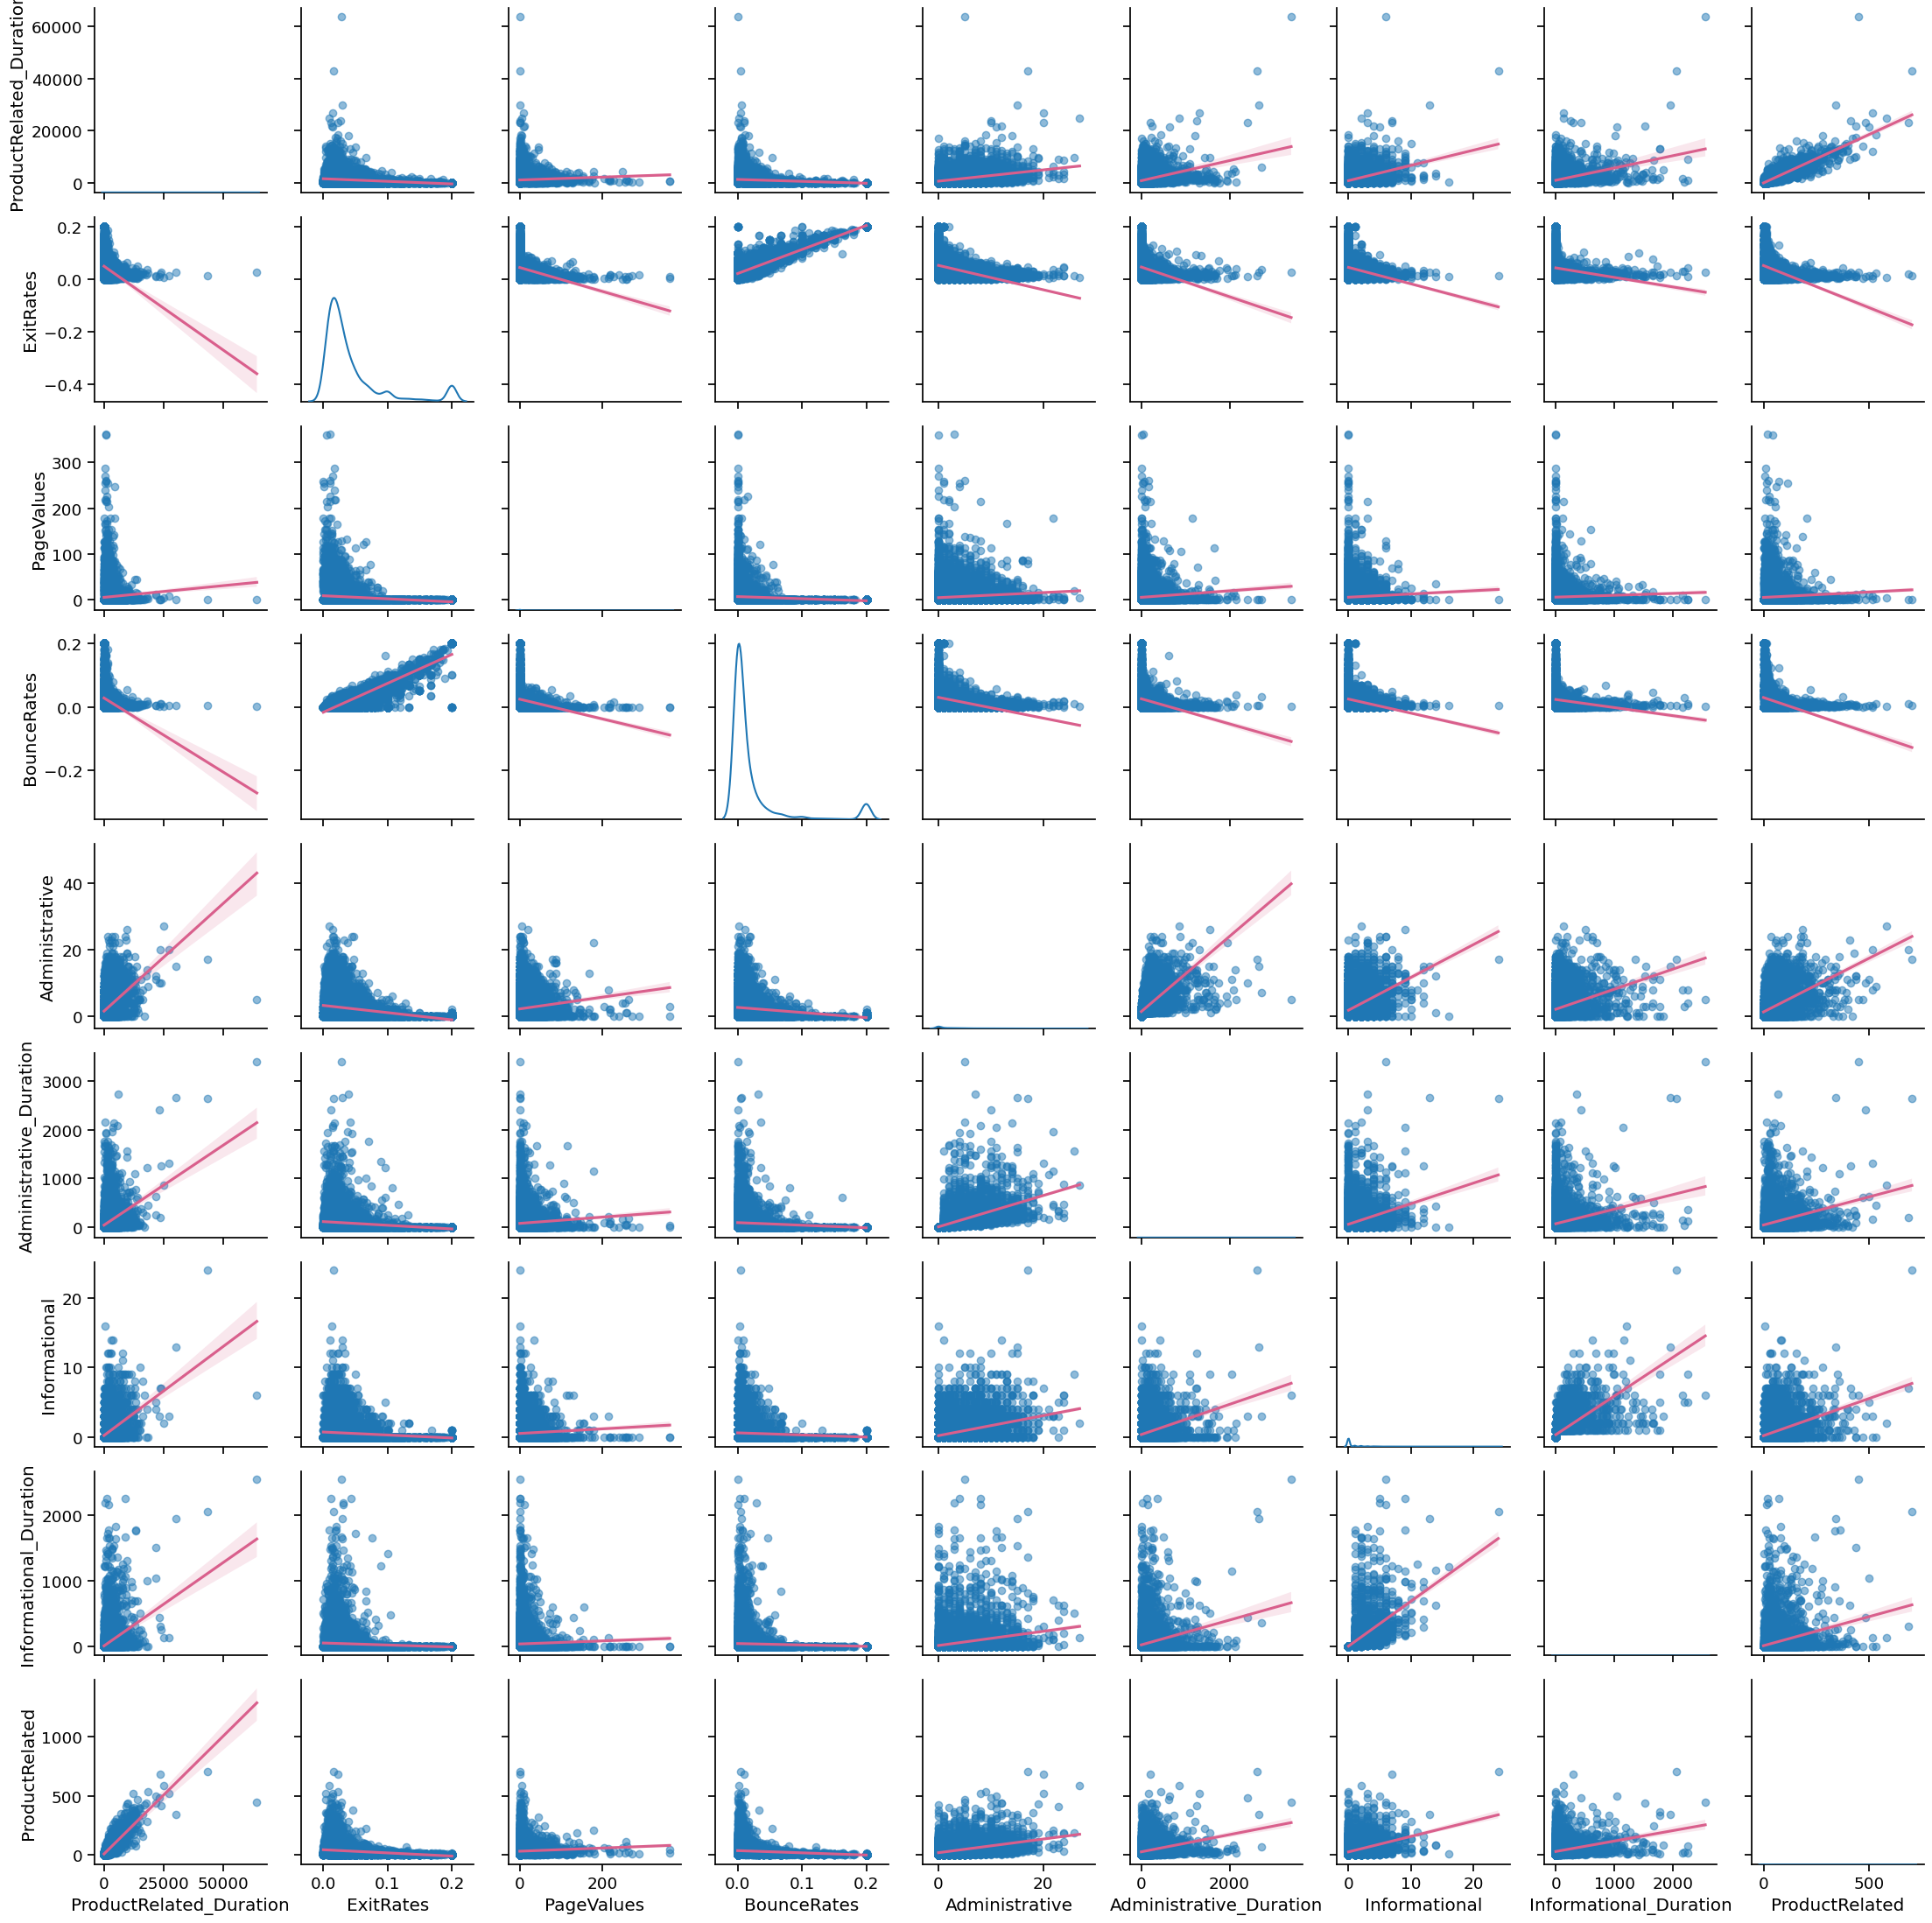

In [43]:
plt.figure(figsize=(18, 6))

sns.set_context("notebook", font_scale=1.2)
g = sns.PairGrid(df[numerical_cols])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.regplot, scatter_kws={'alpha': 0.5}, line_kws={'color': '#d95f8c'})

plt.show()

##### <li> The diagonal plots show that the distributions of the numerical columns are not normal and are right-skewed. we can apply transformations such as <b>log transformation</b>, <b>Box-Cox</b>, or other normalization techniques.</li>
##### <li>In some plots, the points are widely scattered around the regression line, indicating a weak linear relationship. Additionally, potential outliers and deviations from linearity are observed, which may affect model performance if linear assumptions are used.</li>

## ML

In [87]:
num_pipline = Pipeline(
    steps=[ ('scale', MinMaxScaler())]
)


cat_pipline = Pipeline(
    steps=[('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]
)


ordinal_cat_pipline = Pipeline(
    steps=[('ord_encoder', OrdinalEncoder())]
)

In [96]:
col_tranformer = ColumnTransformer(
    transformers=[
        ('num_pipline', num_pipline, numerical_cols),
        ("cat_pipline", cat_pipline, categorical_cols),
        ('ordinal_cat_pipline', ordinal_cat_pipline, ordinal_cat_cols)
    ], 
    remainder='drop'
)

feature_selection =  Pipeline(steps=[('feature_selection', SelectKBest(chi2))])

In [ ]:
from sklearn.model_selection  import train_test_split

X = df[numerical_cols + categorical_cols + ordinal_cat_cols]
y = df['Revenue']
y_encoded = LabelEncoder().fit_transform(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=.3, stratify=y_encoded, random_state=0)

### LogisticRegression:

In [97]:
from sklearn.linear_model import LogisticRegression

log_reg_pipline = Pipeline(
    steps=[
        ('column_trans', col_tranformer),
        ('selection', feature_selection),
        ('model', LogisticRegression(random_state=0, max_iter=1000))
    ]
)

In [99]:
log_reg_pipline.fit(X_train, y_train)

score = log_reg_pipline.score(X_valid, y_valid)
print("Socre_log_reg: ", score * 100)

Socre_log_reg:  87.61827520951609


In [109]:
from sklearn.model_selection import GridSearchCV

param_grid_log_reg = {
    'model__penalty' : ['l1', 'l2'],
     'model__C': [0.1, 1, 10],
    'model__solver' : ['liblinear']
}

grid_log_reg = GridSearchCV(
    log_reg_pipline,
    param_grid=param_grid_log_reg,
    cv=5,
    scoring='accuracy'
)

In [113]:
grid_log_reg.fit(X_train, y_train)

print('best parameter set: ', grid_log_reg.best_params_)
print('score of griding: ', grid_log_reg.score(X_valid, y_valid) * 100)

best parameter set:  {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
score of griding:  88.80778588807786


In [111]:
y_pred_logistic_reg = grid_log_reg.best_estimator_.predict(X_valid)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_pred_logistic_reg )
cm

array([[3068,   59],
       [ 355,  217]], dtype=int64)

### SVC:

In [117]:
from sklearn.svm import SVC

svc_pipline = Pipeline(
    steps=[
        ('column_trans', col_tranformer),
        ('selection', feature_selection),
        ('model', SVC(random_state=0))
    ]
)

In [118]:
svc_pipline.fit(X_train, y_train)

score = svc_pipline.score(X_valid, y_valid)
print("Socre_svc: ", score * 100)

Socre_svc:  88.15896188158962


In [ ]:
param_grid_svc = {
    'model__C': [0.1, 1, 10, 100],           
    'model__gamma': ['scale', 'auto', 0.01, 0.001],  
    'model__kernel': ['rbf', 'linear']        
}


grid_svc = GridSearchCV(
    estimator=svc_pipline,
    param_grid=param_grid_svc,
    cv=5,
    scoring='accuracy'
)


In [120]:
grid_svc.fit(X_train, y_train)

print("Best SVC parameters:", grid_svc.best_params_)
print("Validation score:", grid_svc.score(X_valid, y_valid))

Best SVC parameters: {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Validation score: 0.8921330089213301


In [121]:
y_pred_svc = grid_svc.best_estimator_.predict(X_valid)

In [122]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_pred_svc)
cm

array([[3058,   69],
       [ 330,  242]], dtype=int64)